In [4]:
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from wordfreq import top_n_list
import os
import random
from matplotlib import pyplot as plt
os.chdir("/home/agjma/Equivariance/")

min_length = 3
max_length = 6

_TOP_WORDS = top_n_list("en", float('inf'))
_TOP_WORDS = [w for w in _TOP_WORDS if w.isalpha() and all(c.isascii() and c.isalpha() for c in w)]
_TOP_WORDS = [w for w in _TOP_WORDS if len(w) >= min_length and len(w) <= max_length]
_TOP_WORDS = _TOP_WORDS[:20000]

def visualize_word_pairs(X, y, angle):
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))

    # Show 2 consistent pairs (y=0) in first row
    consistent_indices = np.where(y == 0)[0][:2]
    inconsistent_indices = np.where(y == 1)[0][:6]

    # Plot consistent pairs (y=0)
    for i, idx in enumerate(consistent_indices):
        col = i * 2
        angles = angle[idx]

        axes[0, col].imshow(X[idx, 0], cmap='gray')
        axes[0, col].set_title(f'"{angles:.1f}°\n(Consistent y=0)')
        axes[0, col].axis('off')

        axes[0, col+1].imshow(X[idx, 1], cmap='gray')
        axes[0, col+1].axis('off')

    # Plot inconsistent pairs (y=1)
    for i, idx in enumerate(inconsistent_indices):
        row = 1 + i // 2
        col = (i % 2) * 2
        angles = angle[idx]

        axes[row, col].imshow(X[idx, 0], cmap='gray')
        axes[row, col].set_title(f'{angles:.1f}°\n(Inconsistent y=1)')
        axes[row, col].axis('off')

        axes[row, col+1].imshow(X[idx, 1], cmap='gray')
        axes[row, col+1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def random_word_image(
    n1: int = 3,
    n2: int = 6,
    font_size: int = 100,
    font_path: str | None = None,
    seed: int | None = None,
    image_size: int = 256,
    fg_color: str = "black",
    bg_color: str = "white",
    rotation: float = 0,
    flip_horizontal: bool = False,
    word = None,
):
    if word is None:
        rng = np.random.default_rng(seed)
        pool = [w for w in _TOP_WORDS if n1 <= len(w) <= n2 and w.isalpha()]
        if not pool:
            raise ValueError(f"No words of length {n1}–{n2} in the top‑10 000 list.")

        word = rng.choice(pool).upper()
    else:
        word = word #.upper()

    word = word #.upper()

    # Create the square canvas
    img = Image.new("RGB", (image_size, image_size), bg_color)
    draw = ImageDraw.Draw(img)
    
    # Start with the requested font size and adjust to fit
    current_font_size = font_size
    
    while current_font_size > 10:  # Minimum font size
        # Pick a font (falls back to PIL's default if Arial not found)
        try:
            if font_path is None:
                font = ImageFont.truetype("impact.ttf", current_font_size)
            else:
                font = ImageFont.truetype(font_path, current_font_size)
        except Exception:
            try:
                font = ImageFont.truetype("arialbd.ttf", current_font_size)
            except Exception:
                try:
                    font = ImageFont.truetype("arial.ttf", current_font_size)
                except Exception:
                    font = ImageFont.load_default(size=current_font_size)
        
        # Measure text size
        bbox = draw.textbbox((0, 0), word, font=font)
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        
        # Check if text fits with some padding (80% of image size)
        max_size = int(image_size * 0.8)
        if w <= max_size and h <= max_size:
            break
        
        # Reduce font size and try again
        current_font_size -= 2
    
    # If rotation or flipping is needed, create text on a temporary image
    if rotation != 0 or flip_horizontal:
        # Create a temporary image large enough to contain rotated text
        temp_size = int(max(w, h) * 1.5)  # Extra space for rotation
        temp_img = Image.new("RGBA", (temp_size, temp_size), (0, 0, 0, 0))
        temp_draw = ImageDraw.Draw(temp_img)
        
        # Draw text centered on temporary image
        temp_x = (temp_size - w) // 2
        temp_y = (temp_size - h) // 2 - bbox[1]
        temp_draw.text((temp_x, temp_y), word, font=font, fill=fg_color)
        
        # Apply horizontal flip if requested
        if flip_horizontal:
            temp_img = temp_img.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Rotate the temporary image if needed
        if rotation != 0:
            temp_img = temp_img.rotate(rotation, expand=False, fillcolor=(0, 0, 0, 0))
        
        # Paste the transformed text onto the main image
        paste_x = (image_size - temp_size) // 2
        paste_y = (image_size - temp_size) // 2
        img.paste(temp_img, (paste_x, paste_y), temp_img)
    else:
        # Calculate centered position
        x = (image_size - w) // 2
        y = (image_size - h) // 2 - bbox[1]  # Adjust for baseline offset
        
        # Draw text centered
        draw.text((x, y), word, font=font, fill=fg_color)

    return img, word


In [6]:
def generate_word_pairs(n_pairs=20000, image_size=256, word_length_range=(3, 6), font_size=100, words=None,
                        font_path=None):
    """
    Generate pairs of word images where each pair contains the same word but with different rotations
    and potentially different flipping states.
    
    Parameters:
    -----------
    n_pairs : int
        Number of word pairs to generate
    image_size : int  
        Size of the square images
    word_length_range : tuple
        Range of word lengths (min, max)
    font_size : int
        Font size for the text
        
    Returns:
    --------
    tuple
        - numpy.ndarray: Array of shape (n_pairs, 2, image_size, image_size) containing the word pairs
        - numpy.ndarray: Array of shape (n_pairs,) containing labels:
          * 0 if both images have consistent flipping (both flipped or both not flipped)
          * 1 if only one image is flipped (inconsistent flipping)
        - list: List of words used for each pair
        - numpy.ndarray: Array of rotation angles for each image in degrees
    """
    
    # Initialize the output arrays
    word_pairs = np.zeros((n_pairs, 2, image_size, image_size), dtype=np.uint8)
    flip_labels = np.zeros(n_pairs, dtype=np.uint8)
    rotation_angles = np.zeros((n_pairs), dtype=np.float32)

    if words is None:
        words = np.random.choice(_TOP_WORDS, size=n_pairs, replace=False)
    
    rng = np.random.default_rng()
    
    for i in tqdm(range(n_pairs), desc="Generating word pairs"):
        # Generate two different rotation angles (in degrees)
        rotation1 = rng.uniform(0, 360)
        rotation2 = rng.uniform(0, 360)


        rotation1_rad = np.deg2rad(rotation1)
        rotation2_rad = np.deg2rad(rotation2)

        angle_diff = abs(rotation2_rad - rotation1_rad)
        # Take the minimum of the angle and its complement to 2π
        angle_diff = min(angle_diff, 2 * np.pi - angle_diff)

        rotation_angles[i] = angle_diff
        
        # Use the same seed for both images to ensure same word
        seed = rng.integers(0, 2**32)
        
        # Decide on flipping strategy
        # 50% chance for consistent flipping (both flipped or both not flipped) -> y = 0
        # 50% chance for inconsistent flipping (only one flipped) -> y = 1
        is_inconsistent = rng.random() < 0.5
        
        if is_inconsistent:
            # Inconsistent flipping: one flipped, one not
            flip_labels[i] = 1
            flip1 = rng.random() < 0.5  # Randomly choose which one to flip
            flip2 = not flip1
        else:
            # Consistent flipping: both flipped or both not flipped
            flip_labels[i] = 0
            both_flipped = rng.random() < 0.5  # Randomly choose if both are flipped
            flip1 = both_flipped
            flip2 = both_flipped
        
        # Generate first image
        img1, word1 = random_word_image(
            n1=word_length_range[0],
            n2=word_length_range[1],
            font_size=font_size,
            seed=seed,
            image_size=image_size,
            rotation=rotation1,
            flip_horizontal=flip1,
            word=words[i],
            font_path=font_path
        )
        
        # Generate second image with same word (same seed)
        img2, word2 = random_word_image(
            n1=word_length_range[0],
            n2=word_length_range[1],
            font_size=font_size,
            seed=seed,
            image_size=image_size,
            rotation=rotation2,
            flip_horizontal=flip2,
            word=words[i],
            font_path=font_path
        )
        
        # Convert PIL images to numpy arrays (grayscale)
        # Since images are black text on white background, we can use any channel
        arr1 = np.array(img1)[:, :, 0]  # Use red channel (all channels are the same)
        arr2 = np.array(img2)[:, :, 0]  # Use red channel (all channels are the same)
        
        # Store in the output array
        word_pairs[i, 0] = arr1
        word_pairs[i, 1] = arr2
    
    return word_pairs, flip_labels, rotation_angles, words


In [147]:
# Generate a pair of images for the word "STATE"
word_pair, flip_label, rotation_angle, word = generate_word_pairs(
    n_pairs=1,
    image_size=512,
    word_length_range=(5, 5),  # "STATE" has 5 letters
    font_size=140,
    words=["SRAYM"],
    #font_path='/home/agjma/Equivariance/PseudoSloan.ttf'
)

Generating word pairs: 100%|██████████| 1/1 [00:00<00:00, 42.07it/s]


Generating word pairs: 100%|██████████| 200/200 [00:02<00:00, 98.93it/s] 


Dataset shape: (200, 2, 256, 256)
Dataset dtype: uint8
Memory usage: 25.0 MB
Rotation angles shape: (200,)


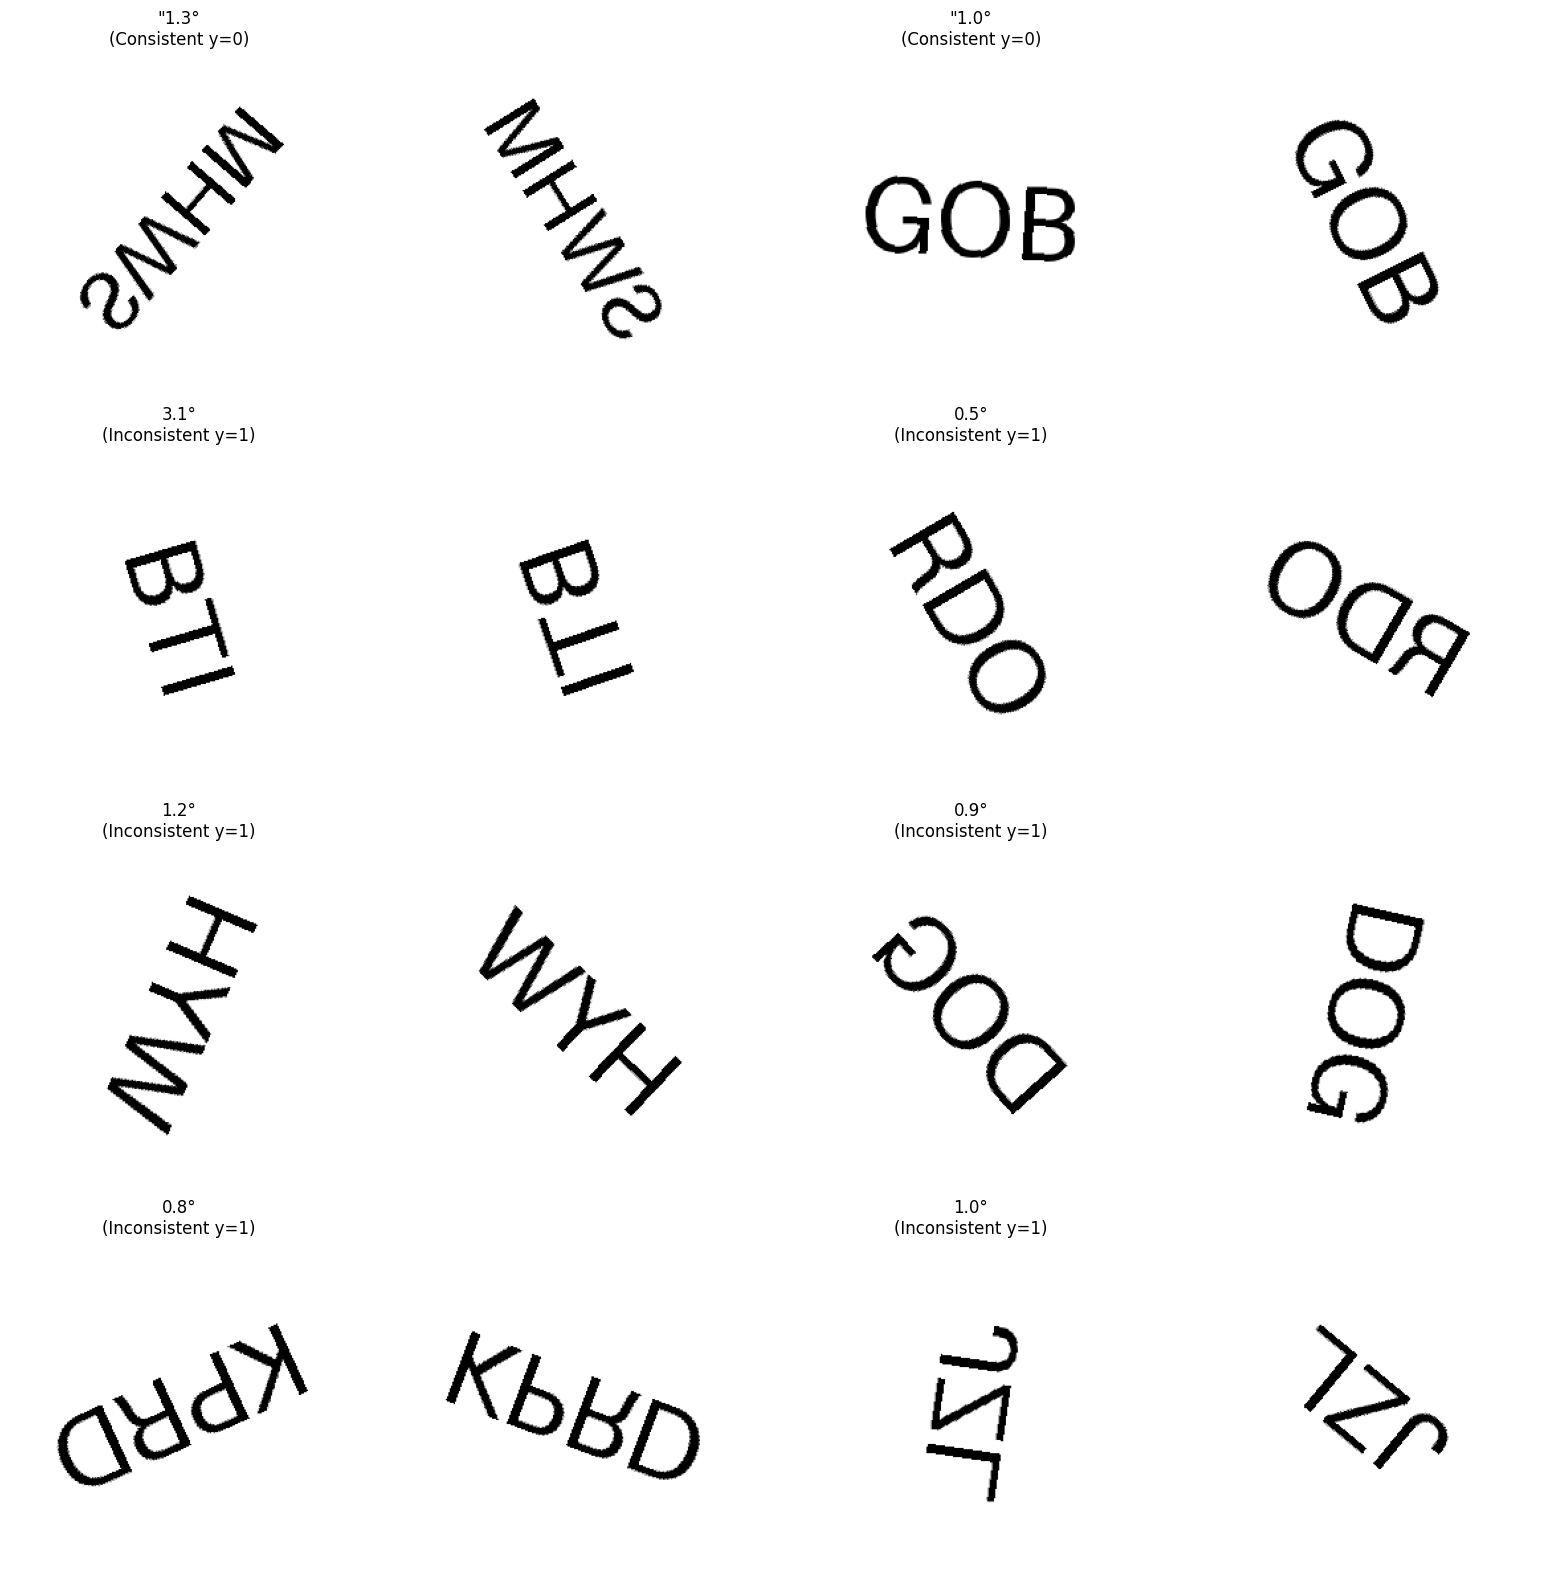

In [10]:
# Generate the word dataset
import random
random_words = [''.join(random.sample('ABCDEFGHIJKLMNOPQRSTUVWXYZ', len(word))) for word in _TOP_WORDS]

word_dataset, word_flip_labels, rotation_angles, words = generate_word_pairs(
    n_pairs=200, 
    image_size=256,  # Using same size as polygon dataset
    word_length_range=(min_length, max_length),
    font_size=80,  # Reduced font size for 128x128 images
    words=random_words
)

print(f"Dataset shape: {word_dataset.shape}")
print(f"Dataset dtype: {word_dataset.dtype}")
print(f"Memory usage: {word_dataset.nbytes / 1024**2:.1f} MB")
print(f"Rotation angles shape: {rotation_angles.shape}")

visualize_word_pairs(word_dataset, word_flip_labels, rotation_angles)
# np.savez('/scratch/agjma/Sebastian/Datasets/words_random.npz', X=word_dataset.reshape(20000, 2, 256, 256, 1), y=word_flip_labels, angle=rotation_angles)

Generating word pairs: 100%|██████████| 20000/20000 [04:50<00:00, 68.80it/s]


Dataset shape: (20000, 2, 256, 256)
Dataset dtype: uint8
Memory usage: 2500.0 MB
Rotation angles shape: (20000,)


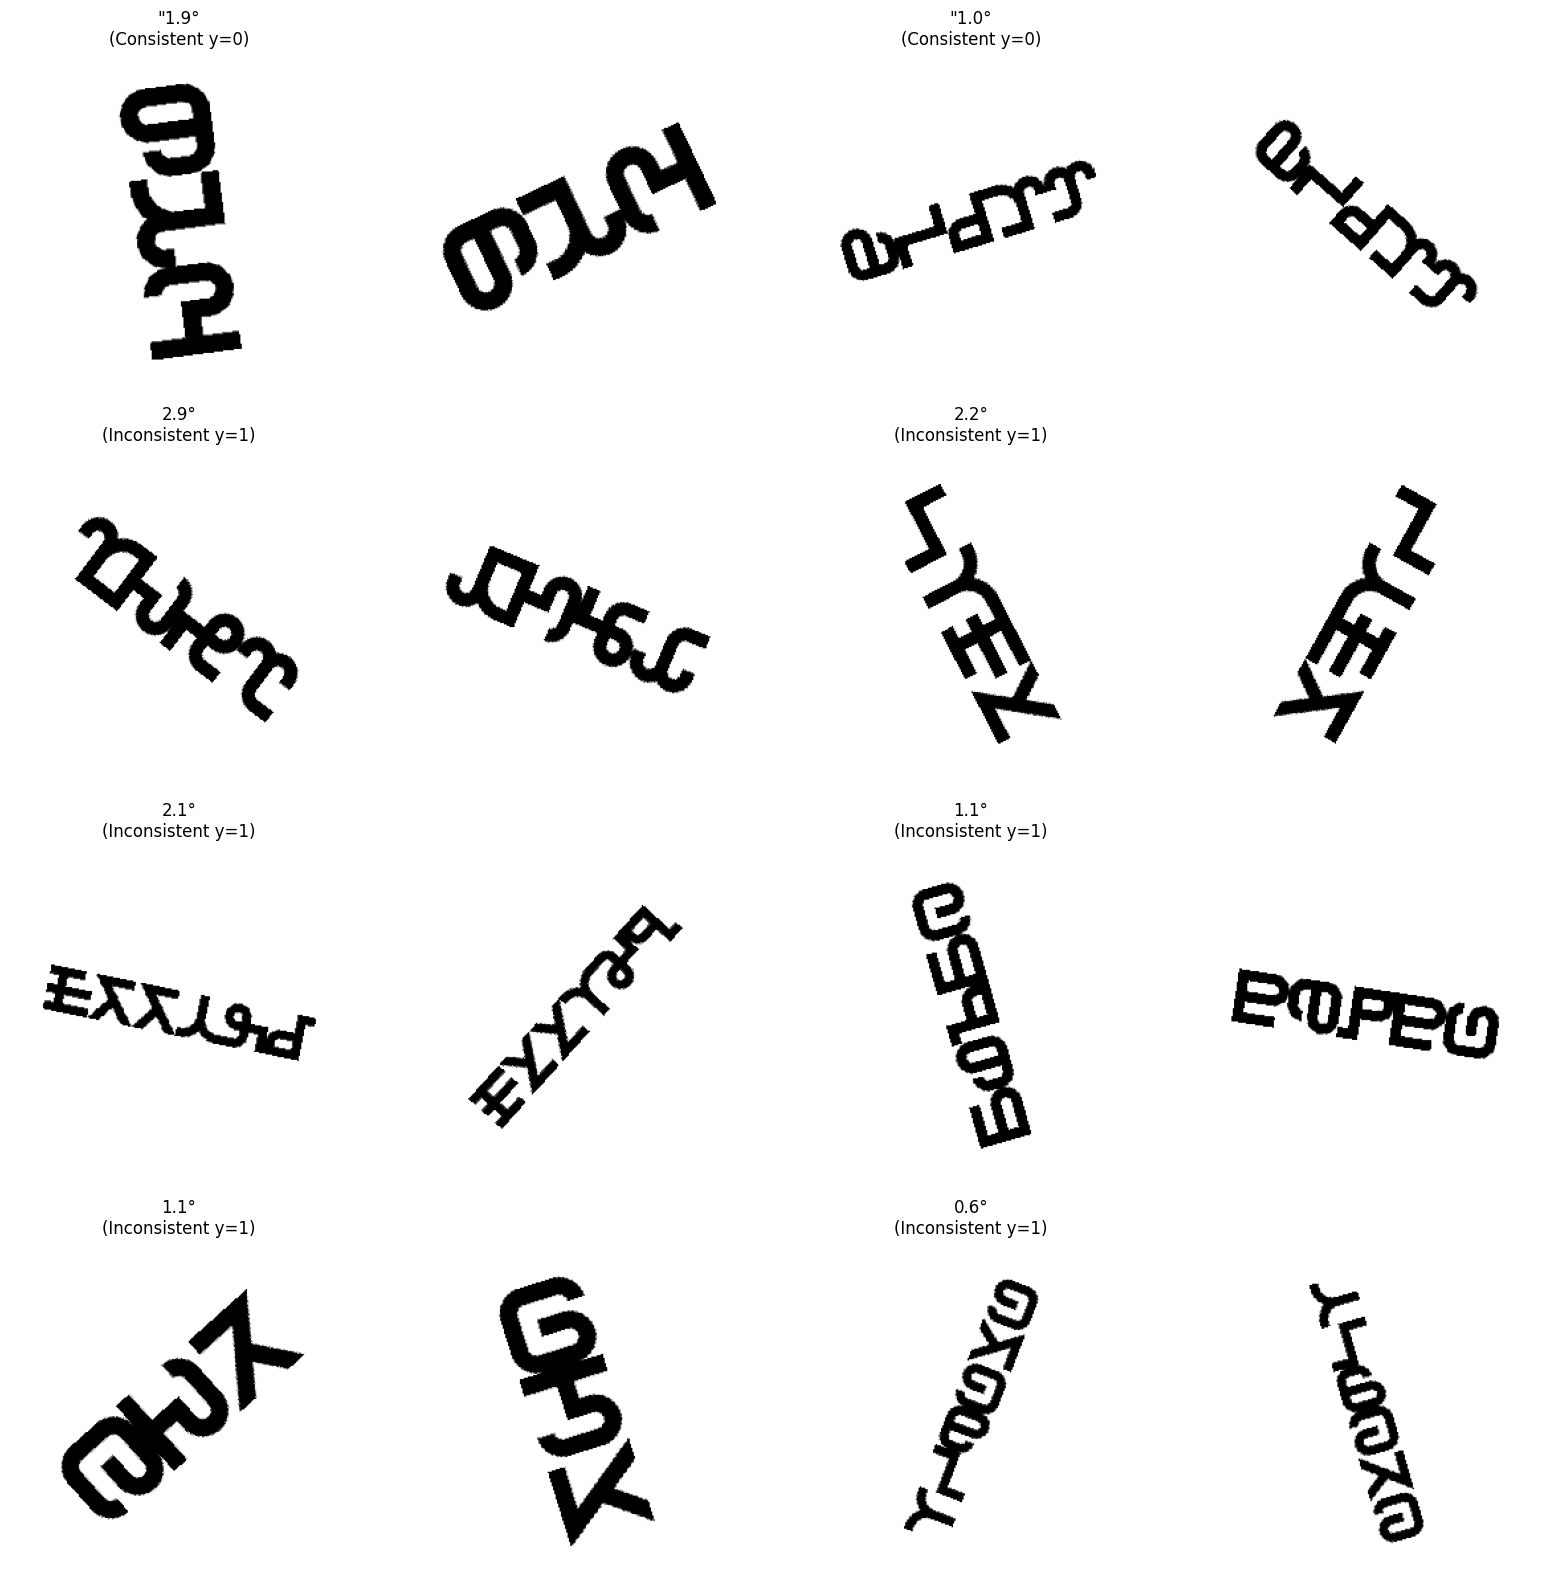

In [14]:
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
alphabet_subset_1, alphabet_subset_2 = np.array_split(np.random.permutation(list(alphabet)), 2)

# Randomly split _TOP_WORDS into two halves
_TOP_WORDS_1, _TOP_WORDS_2 = np.array_split(np.random.permutation(_TOP_WORDS), 2)

# Generate random words for each subset
random_words_1 = [
    ''.join(random.choices(alphabet_subset_1, k=len(word)))
    for word in _TOP_WORDS_1
]
random_words_2 = [
    ''.join(random.choices(alphabet_subset_2, k=len(word)))
    for word in _TOP_WORDS_2
]

assert len(random_words_1) == len(random_words_2) == 10000

random_words = list(np.concatenate([random_words_1, random_words_2]))

# Make each letter of each word lowercase
random_words = [word.lower() for word in random_words]

word_dataset, word_flip_labels, rotation_angles, words = generate_word_pairs(
    n_pairs=20000, 
    image_size=256,  # Using same size as polygon dataset
    word_length_range=(min_length, max_length),
    font_size=80,
    words=random_words,
    font_path='/home/agjma/Equivariance/PseudoSloan.ttf'
)

print(f"Dataset shape: {word_dataset.shape}")
print(f"Dataset dtype: {word_dataset.dtype}")
print(f"Memory usage: {word_dataset.nbytes / 1024**2:.1f} MB")
print(f"Rotation angles shape: {rotation_angles.shape}")

visualize_word_pairs(word_dataset, word_flip_labels, rotation_angles)